# Convolution Neural Net (CNN)
to detect apples

# Imports

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import modules.cosmos_functions as cf

import pprint
import random
import torch
import torchvision
import torch.nn.functional as F

import torchvision.transforms as T
import wandb

from datetime import datetime
from os import listdir, path
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torchvision.io import ImageReadMode
from torchvision.io import read_image
from tqdm import tqdm

In [6]:
# set the device

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
x = torch.ones(1, device=device)

print(f"Device is '{device}' Thus a tensor will look like this: {x}")

Device is 'mps' Thus a tensor will look like this: tensor([1.], device='mps:0')


In [7]:
# function to show the images


def reverse_normalize(image):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = image.clone()
    for i in range(3):
        image[i] = (image[i] * std[i]) + mean[i]
    return image

def show_batch(train_d, val_d):
    # Get a batch of data from the DataLoader
    data_train = next(iter(train_d))
    data_val = next(iter(val_d))

    # Set the savefig.bbox parameter to 'tight'
    plt.rcParams["savefig.bbox"] = 'tight'

    # Retrieve the first tensor and its corresponding label
    image_train = data_train[0][0]
    # image_test = data_test[0][0]
    image_val = data_val[0][0]
    label_train = data_train[1][0]
    # label_test = data_test[1][0]
    label_val = data_val[1][0]

    # Reverse the normalization of the images
    image_train = reverse_normalize(image_train)
    # image_test = reverse_normalize(image_test)
    image_val = reverse_normalize(image_val)

    # Convert the image tensors to NumPy arrays and transpose the dimensions
    np_image_train = image_train.permute(1, 2, 0).numpy()
    # np_image_test = image_test.permute(1, 2, 0).numpy()
    np_image_val = image_val.permute(1, 2, 0).numpy()

    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 2)

    # Display the image in the first subplot
    axes[0].imshow(np_image_train)
    axes[0].set_title(f'{label_train}, {image_train.shape}')

    # Display the image in the third subplot
    axes[1].imshow(np_image_val)
    axes[1].set_title(f'{label_val}, {image_val.shape}')

    # # Display the image in the second subplot
    # axes[2].imshow(np_image_test)
    # axes[2].set_title(f'{label_test}, {image_test.shape}')

    # Adjust spacing between subplots to prevent overlap
    fig.tight_layout()

    # Show the plot
    plt.show()


In [8]:
# function to determine accuracy 

def evaluate_accuracy(logits, y_true):
    # get index with the largest logit value PER OBSERVATION
    _, y_pred = torch.max(logits, dim=1)

    # calculate proportion of correct prediction
    correct_pred = (y_pred == y_true).float()  # PyCharm error Unresolved attribute reference 'float' for class 'bool'
    acc = correct_pred.sum() / len(correct_pred)

    return acc * 100

In [9]:
# function to train the model

def train(model, train_loader, val_loader, criterion, optimizer, n_epochs, model_file_name='model.pt',local_save_path='storage/data/generated'):
    # initialize container variable for model performance results per epoch
    history = {
        'n_epochs': n_epochs,
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }   

    # initialize tracker for minimum validation loss and maxiumum validation accuracy
    val_loss_min = np.Inf
    val_loss_epoch = 0
    val_acc_max = 0.0
    val_acc_epoch = 0
    best_results = {
        'val_loss_min': val_loss_min,
        'val_loss_epoch': val_loss_epoch,
        'val_acc_max': val_acc_max,
        'val_acc_epoch': val_acc_epoch
        }    

    model_file_name_loss = f'{str(model_file_name[:-3])}_loss.pt'
    model_file_name_acc = f'{str(model_file_name[:-3])}_acc.pt'
    final_model_file_name = f'{str(model_file_name[:-3])}_final.pt'
    locally_saved_path = local_save_path   

    file_data = { 
                'local_save_path' : locally_saved_path,
                'min_loss_file' : model_file_name_loss,
                'max_acc_file' : model_file_name_acc,
                'final_epoch_file' : final_model_file_name
                  }
    
    early_stopping_counter = 0

    model_safe_loss = f'../{locally_saved_path}/{model_file_name_loss}'
    model_safe_acc = f'../{locally_saved_path}/{model_file_name_acc}'
    model_safe_final = f'../{locally_saved_path}/{final_model_file_name}'

    # loop per epoch
    for epoch in tqdm(range(n_epochs)):
        while early_stopping_counter < 10:
            # initialize tracker for training performance
            train_acc = 0
            train_loss = 0

            ###################
            # train the model #
            ###################

            # prepare model for training
            model.train()

            # loop for each batch
            for data, target in train_loader:
                # move data to device
                data, target = data.to(device), target.to(device)
                
                # STEP 1: clear gradients
                optimizer.zero_grad()
                # STEP 2: forward pass
                output = model(data)
                # STEP 3: calculate the loss
                loss = criterion(output, target)
                # STEP 4: backward pass
                loss.backward()
                # STEP 5: perform parameter update
                optimizer.step()
                # STEP 6: accumulate training loss and accuracy
                train_loss += loss.item() * data.size(0)
                acc = evaluate_accuracy(output, target)
                train_acc += acc.item() * data.size(0)

            ######################
            # validate the model #
            ######################

            # disable gradient calculation
            with torch.no_grad():
                # initialize tracker for validation performance
                val_acc = 0
                val_loss = 0

                # prepare model for evaluation
                model.eval()

                # loop for each batch
                for data, target in val_loader:
                    # move data to device
                    data, target = data.to(device), target.to(device)
                    # STEP 1: forward pass
                    output = model(data)
                    # STEP 2: calculate the loss
                    loss = criterion(output, target)
                    # STEP 3: accumulate validation loss and accuracy
                    val_loss += loss.item() * data.size(0)
                    acc = evaluate_accuracy(output, target)
                    val_acc += acc.item() * data.size(0)


            ####################
            # model evaluation #
            ####################

            # calculate average loss over an epoch
            train_loss /= len(train_loader.sampler)
            val_loss /= len(val_loader.sampler)
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)

            # calculate average accuracy over an epoch
            train_acc /= len(train_loader.sampler)
            val_acc /= len(val_loader.sampler)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)

            # print training progress per epoch
            print(f'Epoch {epoch+1:03} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f} | Train Acc: {train_acc:.2f} | Val Acc: {val_acc:.2f}')

            # save model if validation loss has decreased
            if val_loss <= val_loss_min:
                print(
                    f'Validation loss decreased ({val_loss_min:.5f} --> {val_loss:.5f})  Saving model to {model_file_name}...')
                

                torch.save(model.state_dict(), model_safe_loss)
                val_loss_min = val_loss
                best_results['val_loss_min'] = val_loss_min
                best_results['val_loss_epoch'] = epoch+1
            
            # save model if validation accuracy has decreased
            if val_acc >= val_acc_max:
                print(
                    f'Validation accuracy increased ({val_acc_max:.5f} --> {val_acc:.5f})  Saving model to {model_file_name}...')
                
                torch.save(model.state_dict(), model_safe_acc)
                val_acc_max = val_acc
                best_results['val_acc_max'] = val_acc_max
                best_results['val_acc_epoch'] = epoch+1
            else:
                early_stopping_counter += 1

            # log metrics to wandb
            wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_acc": train_acc, "val_acc": val_acc})

    # save model at the end of training    
    torch.save(model.state_dict(), model_safe_final)

    results = best_results, history, file_data
    
    # return model performance history
    return results

In [10]:
# load the dataset
dataset_path = "../storage/images/apple_cropped"
# transform and normalize the data
transform = T.Compose([
    T.ToTensor(),
    # T.transforms.Resize((256, 256)),
    # T.transforms.RandomCrop((224, 224)),
    T.transforms.RandomHorizontalFlip(),
    T.transforms.RandomVerticalFlip(),
    T.transforms.RandomRotation(25),  # Randomly rotate the image by a maximum of 30 degrees
    T.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Slightly change the image color
    T.transforms.RandomGrayscale(p=0.1),  # Randomly convert the image to grayscale with a probability of 10%
    T.transforms.RandomErasing(p=0.1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),  # Randomly erase rectangular patches of the image with a probability of 10%
    # T.transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3),  # Randomly apply a perspective transformation to the image with a probability of 10%
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(dataset_path, transform=transform)


dataset.class_to_idx
pp = pprint.PrettyPrinter(indent=1)  # Create a PrettyPrinter instance with an indentation of 1 space
pp.pprint(dataset.class_to_idx)  # Use the pprint method to print the dictionary



{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}


torch.Size([3, 224, 224])
212
91


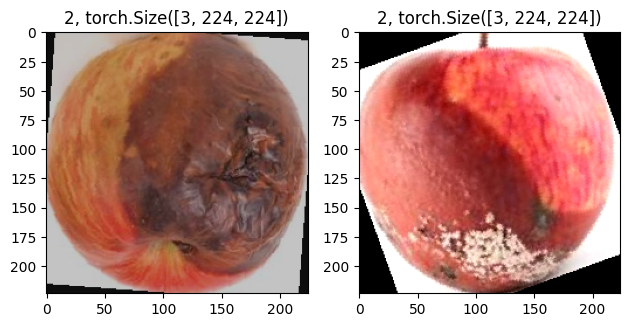

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

In [14]:
# create the test, train and validation set and the dataloader

# setup split data 
dataset_size = len(dataset)
train_ratio = 0.7
val_ratio = 0.3



# Set the seed for the generator
seed = 42
generator = torch.Generator().manual_seed(seed)

# Calculate the number of samples for each split
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size 


# Split the dataset into train, validation, and test sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)


# Define the batch size for the DataLoader
batch_size = 32

# Create the DataLoader to load the dataset in batches
train_d = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2,)
val_d = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# print the shape of the 1st image in the dataset
print(train_dataset[0][0].shape)
print(len(train_dataset))
print(len(val_dataset))
# Show the 1st img in the dataset
show_batch(train_d, val_d)
print(train_dataset[0][0])
# Get the values of the middle 4x4 pixels

print(train_dataset[0][0][:, 112:116, 112:116])

In [ ]:
# import the resnet18 model
from torchvision import models
model = models.resnet18(pretrained=True)

# freeze the model parameters
for param in model.parameters():
    param.requires_grad = False
    
# change the last layer of the model to fit the number of classes in the dataset
model.fc = nn.Linear(512, 4)

# move the model to the device  
model.to(device)


In [ ]:
# set the hyperparameters and the model

# hyperparameters
learning_rate = 0.0005
epochs = 50
betas = None  # (0.9, 0.999)
momentum = 0.8
dropout = 0.2
total_epochs = 0  # legacy code

# model parameters

# model = CNN(dropout=dropout) # Create the model
# model.to(device) # set model to device

model.train() # set model to train mode

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=betas)

# loss function
criterion = nn.CrossEntropyLoss()   # Define the loss function  
 
 # set the loaders to the correct names for the training loop
train_loader = train_d
val_loader = val_d

# set epochloss to empty list
epoch_loss = []
# create dictionairies for the hyperparameters and model parameters
hyperparameters = { 'learning_rate' : learning_rate, 'epochs' : epochs, 'momentum' : momentum, 'betas' : betas, 'dropout' : dropout}
model_parameters = { 'model' : 'resnet18', 'optimizer' : 'SGD', 'criterion' : 'CrossEntropyLoss'}  # 'model' : model, 'optimizer' : optimizer, 'criterion' : criterion
parameters = {**hyperparameters, **model_parameters}    # merge the two dictionairies
pp = pprint.PrettyPrinter(indent=1)  


pp.pprint(f'parameters: {parameters}')

In [ ]:
# the training loop
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
userAccountID = cf.settings['userAccountID']
saveFileName = f'{timestamp}_{userAccountID}.pt'

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="resnet18_1st_tests",
    
    # track hyperparameters and run metadata
    config= parameters
)

history = train(
    model, train_loader, val_loader, criterion, optimizer, n_epochs=epochs,
    model_file_name=saveFileName
)

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

print()
print(f'best results: {history[0]}')
print()
print(f'alot is: {history[1]}')
print()
print(f'save path = {history[2]}')

In [ ]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the training and validation loss
axs[0].plot(history[1]['train_loss'], label='train_loss')
axs[0].plot(history[1]['val_loss'], label='val_loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss over training epochs')
axs[0].legend()

# Plot the training and validation accuracy
axs[1].plot(history[1]['train_acc'], label='train_acc')
axs[1].plot(history[1]['val_acc'], label='val_acc')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy over training epochs')
axs[1].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

In [ ]:
# show the save paths from history
history

save the data to azure cosmos NoSQL database


In [ ]:
local_saved_path= list(history[2].values())[0]
model_file_name_loss = list(history[2].values())[1]
print(f'{list(history[2].values())[0]}/{list(history[2].values())[1]}')

model_file_name_loss= f'{list(history[2].values())[0]}/{list(history[2].values())[1]}'
print(model_file_name_loss)

In [ ]:
## save the model to cosmos db
# Azure Cosmos NoSQL db seems to refuse the size of the model file.

# import time

# model_file_name_loss= f'../{list(history[2].values())[0]}/{list(history[2].values())[1]}'
# model_file_name_acc = f'../{list(history[2].values())[0]}/{list(history[2].values())[2]}'
# model_file_name_final = f'../{list(history[2].values())[0]}/{list(history[2].values())[3]}'
# # model_file_name_loss= './20230605-103225_pinky_loss.pt' 
# # model_file_name_acc = './20230605-103225_pinky_acc.pt'
# # model_file_name_final = './20230605-103225_pinky_final.pt'
# print(model_file_name_loss)
# print(model_file_name_acc)
# print(model_file_name_final)


# pulled_loss = cf.save_data(model_file_name_loss, parameters, history, )
# time.sleep(2)
# pulled_acc = cf.save_data(model_file_name_acc, parameters, history)
# time.sleep(2)
# pulled_final = cf.save_data(model_file_name_final, parameters, history)

test


In [ ]:
print(pulled_final)

# WIP loader loads a wrong data type.